# Train

In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import pickle

X = pickle.load(open('./data/sample224.bgrbayer', 'rb'))
y = pickle.load(open('./data/sample224.real', 'rb'))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=501)

In [4]:
import numpy as np

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
X_train.shape

(10001, 224, 224, 3)

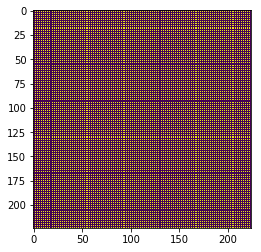

In [6]:
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[765][:, :, 0])

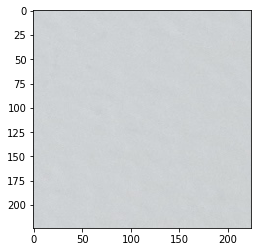

In [7]:
plt.imshow(cv2.cvtColor(y[765], cv2.COLOR_BGR2RGB))

In [8]:
import numpy as np

np.random.seed(501)

def get_train_generator(X, y, batch_size):
    while True:
        sample_indices = np.random.choice(X.shape[0], batch_size)
        inputs, targets = X[sample_indices] / 255, y[sample_indices] / 255
        yield inputs, targets

In [9]:
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda, Dropout

inputs = Input(shape=(None, None, 3))
# conv = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='tanh')(inputs)
# dropout = Dropout(0.4)(conv)
conv1 = Conv2D(filters=3, kernel_size=(5, 1), padding='same', activation='linear')(inputs)
conv2 = Conv2D(filters=3, kernel_size=(1, 5), padding='same', activation='relu')(conv1)

prediction = Lambda(lambda x: K.minimum(x, 1))(conv2)

In [10]:
import keras.backend as K
import numpy as np

def psnr(y_true, y_pred):
    return 10. * K.log(K.mean(K.square(y_pred - y_true))) / np.log(10)

In [11]:
from keras.models import Model

model = Model(inputs=inputs, outputs=prediction)

In [12]:
model.compile(optimizer='adam',
              loss=[psnr],
              metrics=['mse']
             )

In [13]:
X_test.shape

(1112, 224, 224, 3)

In [14]:
model.fit_generator(get_train_generator(X_train, y_train, 32), steps_per_epoch=500, 
                    validation_data=(X_test / 255, y_test / 255), epochs=20)

Epoch 1/20
500/500 [==============================] - 36s 73ms/step - loss: -20.0483 - mean_squared_error: 0.0175 - val_loss: -23.5051 - val_mean_squared_error: 0.0046
Epoch 2/20
500/500 [==============================] - 25s 50ms/step - loss: -27.1417 - mean_squared_error: 0.0023 - val_loss: -29.7971 - val_mean_squared_error: 0.0011
Epoch 3/20
500/500 [==============================] - 25s 50ms/step - loss: -31.7810 - mean_squared_error: 7.5498e-04 - val_loss: -33.4332 - val_mean_squared_error: 4.8524e-04
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: -33.8668 - mean_squared_error: 4.5236e-04 - val_loss: -34.0532 - val_mean_squared_error: 4.2202e-04
Epoch 5/20
500/500 [==============================] - 25s 51ms/step - loss: -34.1483 - mean_squared_error: 4.3822e-04 - val_loss: -34.4286 - val_mean_squared_error: 3.8738e-04
Epoch 6/20
500/500 [==============================] - 26s 53ms/step - loss: -34.4599 - mean_squared_error: 4.0538e-04 - val_loss: -34.67

In [15]:
from keras.models import load_model

model.save('./models/bayerConv5x1x5.h5')
model.summary()
img = model.predict(X_test[404:405] / 255)[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 3)     48        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     48        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


# Test

In [25]:
import numpy as np

masks = dict()
def get_masks(x_size, y_size):
    green_mask = np.zeros(x_size * y_size, dtype=np.uint8).reshape(x_size, y_size)
    blue_mask = np.zeros(x_size * y_size, dtype=np.uint8).reshape(x_size, y_size)
    red_mask = np.zeros(x_size * y_size, dtype=np.uint8).reshape(x_size, y_size)
    
    if (x_size, y_size) in masks:
        return masks[(x_size, y_size)]
    
    for i in range(x_size):
        for j in range(y_size):
            if i % 2 == 0 and j % 2 == 1:
                red_mask[i][j] = 1
            elif i % 2 == 1 and j % 2 == 0:
                blue_mask[i][j] = 1
            else:
                green_mask[i][j] = 1
    masks[(x_size, y_size)] = green_mask, blue_mask, red_mask
    return green_mask, blue_mask, red_mask
            
            
def get_bayer_image(source):
    green_mask, blue_mask, red_mask = get_masks(source.shape[0], source.shape[1])
    bayer_image = np.zeros(source.shape, dtype=np.uint8)
    bayer_image[:, :, 0] = source[:, :, 0] * blue_mask
    bayer_image[:, :, 1] = source[:, :, 1] * green_mask
    bayer_image[:, :, 2] = source[:, :, 2] * red_mask
    return bayer_image

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


from keras.models import load_model
import keras.backend as K

def psnr(y_true, y_pred):
    return 10. * K.log(K.mean(K.square(y_pred - y_true))) / np.log(10)

model = load_model('./models/bayerConv5x1x5.h5', custom_objects={'psnr': psnr})

In [22]:
import cv2

test_path = './Original.bmp'
test = cv2.imread(test_path)

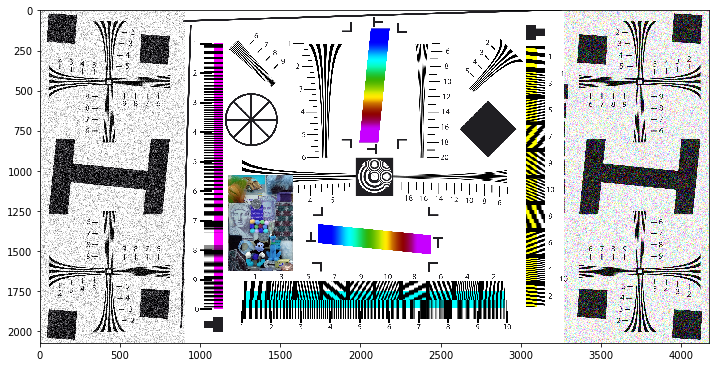

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12, 8))
plt.imshow(test / 255)
plt.show()

In [26]:
bayer_test = get_bayer_image(test)

In [27]:
test_path = './RGB_CFA.bmp'
bayer_test_original = cv2.imread(test_path)

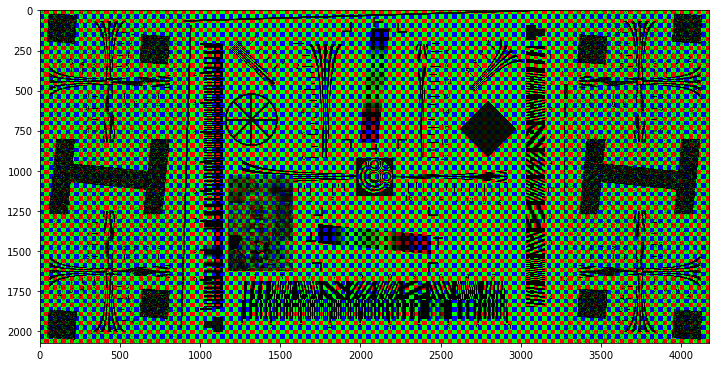

In [28]:
plt.figure(figsize=(12, 8))
plt.imshow(bayer_test / 255)
plt.show()

In [29]:
%%time
ans_test = model.predict(bayer_test.reshape(1, *test.shape) / 255)

CPU times: user 871 ms, sys: 784 ms, total: 1.66 s
Wall time: 1.67 s


In [30]:
model.evaluate(bayer_test.reshape(1, *test.shape) / 255, test.reshape(1, *test.shape) / 255)

1/1 [==============================] - 0s 389ms/step


[-21.3494930267334, 0.007329100277274847]

In [25]:
model.evaluate(bayer_test_original.reshape(1, *test.shape) / 255, test.reshape(1, *test.shape) / 255)

1/1 [==============================] - 0s 388ms/step


[-21.95606803894043, 0.0063737235032022]

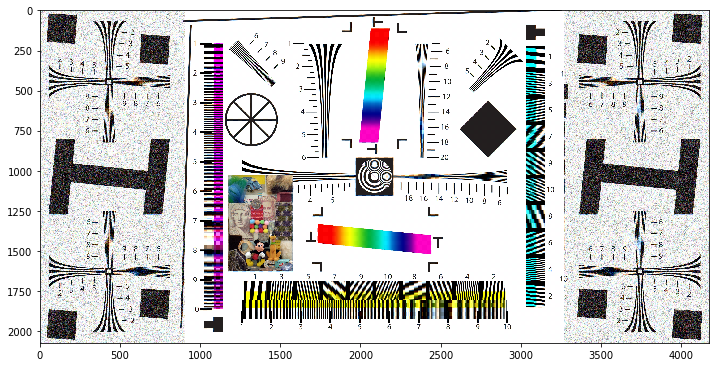

In [54]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor((ans_test[0] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [112]:
np_psnr(scipy_test, test / 255)

22.08818818672399

In [55]:
np_psnr(ans_test, test / 255)

NameError: name 'np_psnr' is not defined

In [47]:
test_ans_path = 'Reconstructed.bmp'

cv2.imwrite(test_ans_path, (ans_test[0] * 255).astype(np.uint8))

True

In [48]:
((ans_test[0] - test / 255) ** 2).sum() / test.shape[0] / test.shape[1]

0.00019162514135943705

In [49]:
bayer_gray = bayer_test.sum(axis=2, dtype=np.uint8)

In [50]:
%%time
cv_test_ans = cv2.cvtColor(bayer_gray, cv2.COLOR_BAYER_GB2RGB)

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 3.36 ms


In [51]:
((cv_test_ans / 255 - test / 255) ** 2).sum() / test.shape[0] / test.shape[1]

0.07075158822301915

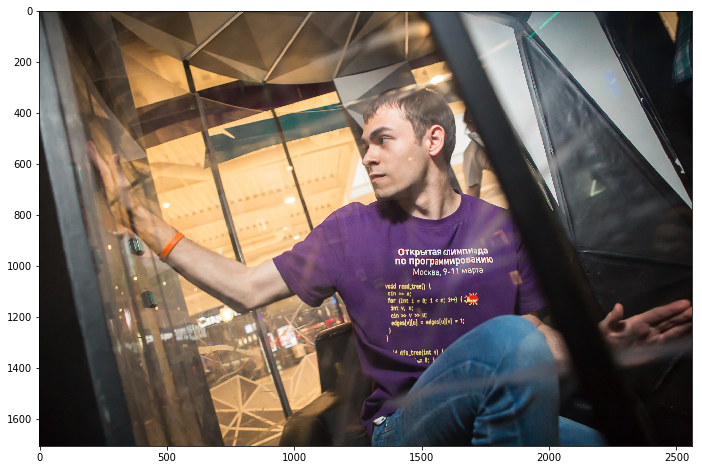

In [52]:
plt.figure(figsize=(12, 8))
plt.imshow(cv_test_ans)
plt.show()

In [53]:
def np_psnr(y_true, y_pred):
    return -10. * np.log(np.mean(np.square(y_pred - y_true))) / np.log(10)

In [54]:
np_psnr(cv_test_ans / 255, test / 255)

16.27385061424375

In [55]:
np_psnr(ans_test, test / 255)

41.9466876648358

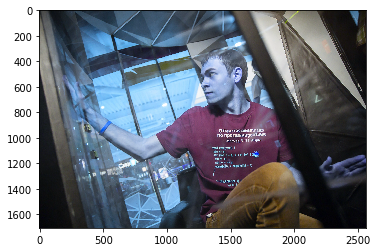

In [29]:
plt.imshow(ans_test[0])